# Part 3, finall version - RNN, LSTM, GRU 

In [101]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader

from src import *

## Create dataloader, example

In [102]:
dataloader = CSVDataLoader('data/MSFT_2006-01-01_to_2018-01-01.csv')
X_train_1, X_test_1 = dataloader.split_by_year([2006, 2007], [2008])

training_dataset_1 = StockTorchDataset(X_train_1, zscore_params=None, history=5)
testing_dataset_1 = StockTorchDataset(X_test_1, zscore_params=training_dataset_1.get_zscore_params(), history=5)

training_loader_1 = DataLoader(training_dataset_1, batch_size=1, shuffle=False, drop_last=False)
testing_loader_1 = DataLoader(testing_dataset_1, batch_size=1, shuffle=False, drop_last=False)

## Train and evaluate models

In [103]:
# Define train function
def train(model: torch.nn.Module,
        dataloader: DataLoader,
        test_loader: DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        total_epochs: int = 100,
        accum_steps: int = 8,
) -> None:
    model.train()
    optimizer.zero_grad()

    train_losses, test_losses = [], []

    pbar = tqdm(range(total_epochs), desc="Epochs", dynamic_ncols=True, leave=False)
    for epoch in pbar:
        epoch_loss = 0.0
        num_steps = 0.0
        h = None
        for step, (x, y) in enumerate(dataloader):
            x = x.view(x.size(0), 1, -1)
            output, h = model(x, h)            
            loss = loss_fn(output, y)
            loss.backward()

            # accumulate loss
            epoch_loss += loss.item()
            num_steps += 1
    
            # update after accum_steps
            if (step + 1) % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            # detach hidden state
            if isinstance(h, tuple):
                h = (h[0].detach(), h[1].detach())
            else:
                h = h.detach()
        
        if (step + 1) % accum_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
    
        # Print epoch loss
        avg_loss = epoch_loss / num_steps
        pbar.set_postfix(loss=f"{avg_loss:.6f}")

        _, _, test_mae = evaluate(model=model, dataloader=test_loader, loss_fn=loss_fn)

        train_losses.append(avg_loss)
        test_losses.append(test_mae)
    return avg_loss, train_losses, test_losses
    
# Define evaluate function
@torch.no_grad()
def evaluate(
    model: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: torch.nn.Module,
) -> None:
    model.eval()
    preds_list, targets_list = [], []
    tot_loss = 0.0
    num_steps = 0.0
    h = None

    for x, y in dataloader:
        x = x.view(x.size(0), 1, -1)
        output, h = model(x, h)
        loss = loss_fn(output, y)

        # accumulate loss
        tot_loss += loss.item()
        num_steps += 1

        preds_list.append(output)
        targets_list.append(y)

        # detach hidden state
        if isinstance(h, tuple):
            h = (h[0].detach(), h[1].detach())
        else:
            h = h.detach()
        
    # Print eval loss
    avg_loss = tot_loss / num_steps

    preds = torch.cat(preds_list, dim=0).numpy()
    targets = torch.cat(targets_list, dim=0).numpy()

    return preds, targets, avg_loss

In [104]:
# Train RNN on first 3 years, test on 4rd year
train_years = list(range(2009, 2011))   
test_year = [2012]        

# Prepare data
history_length = 15
target_days = [1, 10]

X_train, X_test = dataloader.split_by_year(train_years, test_year)
train_dataset = StockTorchDataset(X_train, zscore_params=None, history=history_length, target_days=target_days)
test_dataset = StockTorchDataset(X_test, zscore_params=train_dataset.get_zscore_params(), history=history_length, target_days=[1])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Model, optimizer, loss
input_size = history_length + 1 + 22  # history + today_change + features
hidden_size = 32
num_layers = 2
rnn_type = "LSTM" # Choose one from: "RNN", "LSTM", "GRU", "cutomLSTM"
model = FinallModel(input_size=input_size, hidden_size=hidden_size, rnn_type=rnn_type, num_layers=num_layers, out_dim=len(target_days))
# model = SimpleLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.L1Loss()

# Train model
train_mae, train_losses, test_losses = train(model=model, dataloader=train_loader, test_loader=test_loader, optimizer=optimizer, loss_fn=criterion, total_epochs=30, accum_steps=8)

# Evaluate model
preds, targets, test_mae = evaluate(model=model, dataloader=test_loader, loss_fn=criterion)
print(f"Evaluate mode: loss = {test_mae:.6f}")

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s, loss=0.697817]/home/vondras/anaconda3/envs/PRAML/lib/python3.12/site-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
                                                                      

Evaluate mode: loss = 0.775393


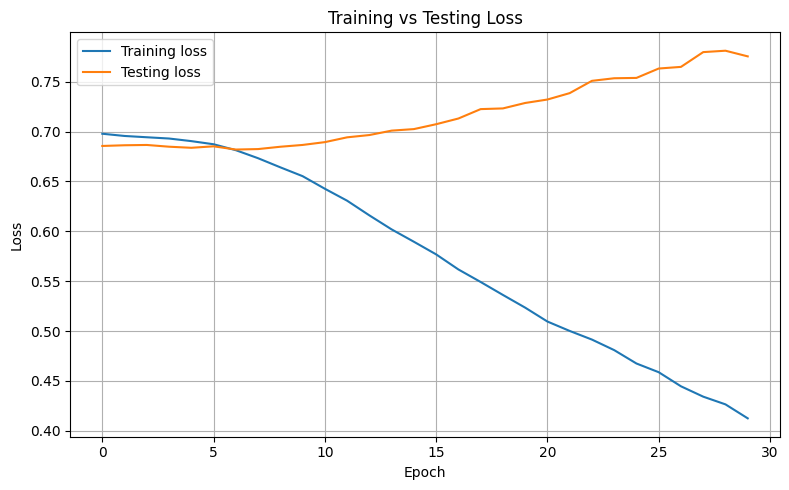

In [105]:
# Training plot
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [106]:
# Results with/without dropout=0.2, LSTM
# without dropout, Evaluate mode: loss = 0.928293
# with dropout, Evaluate mode: loss = 0.898524


# Results for different history_length
# 0 - Evaluate mode: loss = 0.792307
# 1 - Evaluate mode: loss = 0.819751
# 2 - Evaluate mode: loss = 0.848286
# 3 - Evaluate mode: loss = 0.851655
# 4 - Evaluate mode: loss = 0.875273
# 5 - Evaluate mode: loss = 0.924159
# 6 - Evaluate mode: loss = 0.940199
# 7 - Evaluate mode: loss = 0.991592
# 8 - Evaluate mode: loss = 0.980053
# 9 - Evaluate mode: loss = 1.092255
# 10 - Evaluate mode: loss = 1.048559
# 11 - Evaluate mode: loss = 1.010351
# 12 - Evaluate mode: loss = 0.887197
# 13 - Evaluate mode: loss = 0.941856
# 14 - Evaluate mode: loss = 0.992764
# 15 -Evaluate mode: loss = 0.962830

## Evaluation and vizualization

In [107]:
def compute_mae_first_close(preds_close, targets_close, train_ds):
    # z-score parametres
    mu, sigma = train_ds.get_zscore_params()

    # original space
    preds_inv = preds_close * sigma + mu
    targets_inv = targets_close * sigma + mu

    # MAE
    mae = np.mean(np.abs(preds_inv - targets_inv))
    return mae

horiz_index = 0
preds = preds[:,horiz_index]
targets = targets[:,horiz_index]
print(f"Test MAE = {compute_mae_first_close(preds, targets, train_dataset)}")

Test MAE = 0.32573738190978346


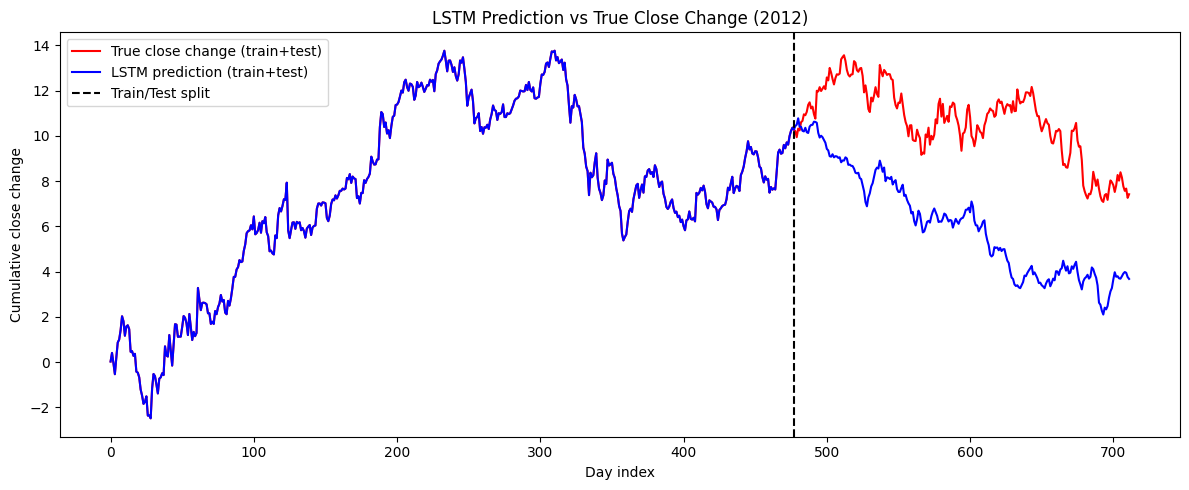

In [108]:
mu, sigma = train_dataset.get_zscore_params()
preds_inv = np.array(preds) * sigma + mu
train_targets = []
for _, y in DataLoader(train_dataset, batch_size=1, shuffle=False):
    train_targets.append(y[:,horiz_index].squeeze(0).item())
train_targets = np.array(train_targets)
train_targets_inv = train_targets * sigma + mu

full_pred = np.concatenate([train_targets_inv, preds_inv.ravel()])
full_true = np.concatenate([train_targets_inv, np.array(targets.ravel()) * sigma + mu])

full_pred_curve = np.cumsum(full_pred)
full_true_curve = np.cumsum(full_true)

plt.figure(figsize=(12,5))
plt.plot(full_true_curve, c="r", label="True close change (train+test)")
plt.plot(full_pred_curve, c="b", label="LSTM prediction (train+test)")
plt.axvline(len(train_targets_inv)-1, color='k', linestyle='--', label='Train/Test split')
plt.title(f"LSTM Prediction vs True Close Change ({test_year[0]})")
plt.xlabel("Day index")
plt.ylabel("Cumulative close change")
plt.legend()
plt.tight_layout()
plt.show()

## Run on whole dataset

In [ ]:
years = np.arange(2006, 2018)
history_length = 15
target_days=[1, 10]
dataloader = CSVDataLoader('data/MSFT_2006-01-01_to_2018-01-01.csv')

print("Sliding window results:")
for i in range(len(years) - 2):
    train_years = [years[i], years[i+1]]
    test_year = [years[i+2]]

    X_train, X_test = dataloader.split_by_year(train_years, test_year)
    train_dataset = StockTorchDataset(X_train, zscore_params=None, history=history_length, target_days=target_days)
    test_dataset = StockTorchDataset(X_test, zscore_params=train_dataset.get_zscore_params(), history=history_length, target_days=[1])
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Model, optimizer, loss
    input_size = history_length + 1 + 22  # history + today_change + features
    hidden_size = 32
    num_layers = 2
    rnn_type = "LSTM" # Choose one from: "RNN", "LSTM", "GRU", "cutomLSTM"
    model = FinallModel(input_size=input_size, hidden_size=hidden_size, rnn_type=rnn_type, num_layers=num_layers)
    # model = SimpleLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.L1Loss()

    # Train model
    train_mae = train(model=model, dataloader=train_loader, test_loader=test_loader, optimizer=optimizer, loss_fn=criterion, total_epochs=30, accum_steps=8)

    # Evaluate model
    preds, targets, test_mae_double = evaluate(model=model, dataloader=test_loader, loss_fn=criterion)

    # Evaluate only 1st prediction (next day)
    horiz_index = 0
    preds = preds[:,horiz_index]
    targets = targets[:,horiz_index]
    test_mae = compute_mae_first_close(preds, targets, train_dataset)
    print(f"Test MAE = {test_mae}")

    print(f"Train years: {train_years}, Test year: {test_year} | Train MAE: {train_mae[0]:.4f}, Test MAE: {test_mae:.4f}")

Sliding window results:


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]/home/vondras/anaconda3/envs/PRAML/lib/python3.12/site-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test MAE = 0.5889437129507599
Train years: [np.int64(2006), np.int64(2007)], Test year: [np.int64(2008)] | Train MAE: 0.5601, Test MAE: 0.5889


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]/home/vondras/anaconda3/envs/PRAML/lib/python3.12/site-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test MAE = 0.3655380370502529
Train years: [np.int64(2007), np.int64(2008)], Test year: [np.int64(2009)] | Train MAE: 0.5714, Test MAE: 0.3655


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]/home/vondras/anaconda3/envs/PRAML/lib/python3.12/site-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test MAE = 0.31615646715983386
Train years: [np.int64(2008), np.int64(2009)], Test year: [np.int64(2010)] | Train MAE: 0.5506, Test MAE: 0.3162


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]/home/vondras/anaconda3/envs/PRAML/lib/python3.12/site-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test MAE = 0.31286269118685284
Train years: [np.int64(2009), np.int64(2010)], Test year: [np.int64(2011)] | Train MAE: 0.5626, Test MAE: 0.3129


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]/home/vondras/anaconda3/envs/PRAML/lib/python3.12/site-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test MAE = 0.3196182483249142
Train years: [np.int64(2010), np.int64(2011)], Test year: [np.int64(2012)] | Train MAE: 0.5949, Test MAE: 0.3196


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]/home/vondras/anaconda3/envs/PRAML/lib/python3.12/site-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test MAE = 0.3737162763060724
Train years: [np.int64(2011), np.int64(2012)], Test year: [np.int64(2013)] | Train MAE: 0.6011, Test MAE: 0.3737


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]/home/vondras/anaconda3/envs/PRAML/lib/python3.12/site-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test MAE = 0.4001406438821251
Train years: [np.int64(2012), np.int64(2013)], Test year: [np.int64(2014)] | Train MAE: 0.5592, Test MAE: 0.4001


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]/home/vondras/anaconda3/envs/PRAML/lib/python3.12/site-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test MAE = 0.6173893503149857
Train years: [np.int64(2013), np.int64(2014)], Test year: [np.int64(2015)] | Train MAE: 0.5743, Test MAE: 0.6174


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]/home/vondras/anaconda3/envs/PRAML/lib/python3.12/site-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test MAE = 0.5626586480236683
Train years: [np.int64(2014), np.int64(2015)], Test year: [np.int64(2016)] | Train MAE: 0.5426, Test MAE: 0.5627


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]/home/vondras/anaconda3/envs/PRAML/lib/python3.12/site-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test MAE = 0.5597567325945899
Train years: [np.int64(2015), np.int64(2016)], Test year: [np.int64(2017)] | Train MAE: 0.5397, Test MAE: 0.5598
